In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [73]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [74]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [75]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(conn, reflect = True)

In [76]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [77]:
# Save references to each table
Mea = Base.classes.measurement
Sta = Base.classes.station

In [78]:
# Create our session (link) from Python to the DB
session = Session(conn)

# Exploratory Precipitation Analysis

In [101]:

# Find the most recent date in the data set.
recent_date = session.query(Mea).order_by(Mea.date.desc()).first().__dict__
recent_date
inspector = inspect(conn)
inspector.get_table_names()
column_info = inspector.get_columns('measurement')
column_info
for column in column_info:
    print(column['name'], column['type'],column['primary_key'])

id INTEGER 1
station TEXT 0
date TEXT 0
prcp FLOAT 0
tobs FLOAT 0


Text(0, 0.5, 'Percipitation')

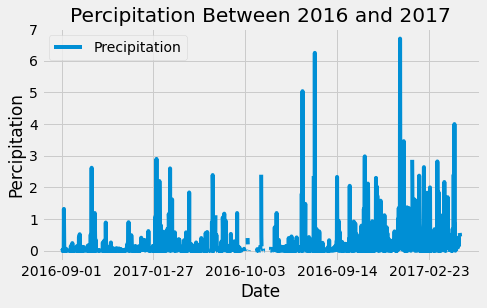

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.

#Parse the recent date with datetime
recent_parsed = dt.datetime.strptime(recent_date['date'],"%Y-%m-%d")
#Create a new string while reducing year by one and parsing the month with 0 before the number.
target_date = f"{recent_parsed.year-1}-{recent_parsed.month:02}"

# Run the session
result = session.query(Mea).filter(func.strftime("%Y-%m",Mea.date) > target_date).all();

# Perform a query to retrieve the data and precipitation scores
precipitation_list = []
for row in result:
    precipitation_list.append([row.date,row.prcp]);
precipitation_list
# Save the query results as a Pandas DataFrame and set the index to the date column
preci_df = pd.DataFrame(precipitation_list, columns= ['Date','Precipitation'])

# Sort the dataframe by date
prec_df_sort = preci_df.set_index('Date')

# Use Pandas Plotting with Matplotlib to plot the data
prec_df_sort.plot(figsize = (7,4))
plt.title('Percipitation Between 2016 and 2017')
plt.ylabel('Percipitation')



In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prec_df_sort.describe()

,Precipitation
count,1968.000000
mean,0.171479
std,0.451817
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [25]:
# Design a query to calculate the total number stations in the dataset
station_tot = session.query(Sta).count()
station_tot


9

In [106]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Mea.station, func.count(Mea.id)).group_by(Mea.station).order_by(func.count(Mea.id).desc()).all()
active_stations
# for stations in active_stations:
#     active_station_list.append(stations[0].__dict__['station'])
# active_station_list

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [112]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_temp = session.query(Mea.station,func.min(Mea.tobs),func.max(Mea.tobs),func.avg(Mea.tobs)).group_by(Mea.station).order_by(func.count(Mea.id).desc()).all()
station_temp

[('USC00519281', 54.0, 85.0, 71.66378066378067),
 ('USC00519397', 56.0, 87.0, 74.55323054331865),
 ('USC00513117', 59.0, 85.0, 72.68918420081211),
 ('USC00519523', 56.0, 85.0, 74.5436493068565),
 ('USC00516128', 58.0, 84.0, 70.91500765696784),
 ('USC00514830', 58.0, 85.0, 74.8732970027248),
 ('USC00511918', 53.0, 87.0, 71.61596766043456),
 ('USC00517948', 58.0, 87.0, 74.68440233236151),
 ('USC00518838', 58.0, 83.0, 72.72407045009784)]

Text(0.5, 0, 'Tempearture')

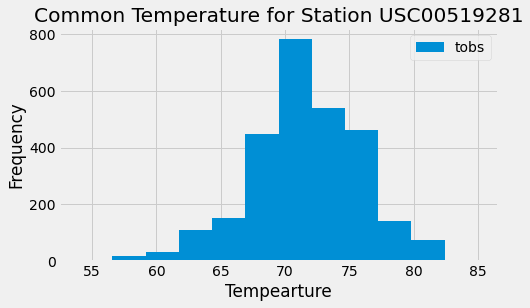

In [128]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_station_data = session.query(Mea.date,Mea.tobs).filter(Mea.station == station_temp[0][0]).all()
station_df = pd.DataFrame(active_station_data, columns = ['Date','tobs'])
station_sort = station_df.set_index('Date')
station_sort.plot.hist(figsize = (7,4), bins=12)
plt.title(f'Common Temperature for Station {station_temp[0][0]}')
plt.xlabel('Tempearture')

# Close session

In [126]:
# Close Session
session.close()